In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
import random

In [2]:
NUM_WORDS = 5000
max_review_length = 100
INDEX_FROM = 3

# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X, y), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X[1000] ))

# --- filter sequences with at least 170 words
TOTAL_LENGTH = 170
X = [lst for lst in X if len(lst) >= TOTAL_LENGTH]
# --- truncate input sequences
X = sequence.pad_sequences(X, maxlen=TOTAL_LENGTH, truncating='post')
# # --- Keep only 100 sequences
N = 200
X = X[:N]

print("X shape:", X.shape)
print("len(X[0]):", len(X[0]))
print("len(X[1]):", len(X[1]))
print("X[0]:", X[0])

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [3]:
LENGTH_TRAIN = 100
LENGTH_TEST = 70
X_train = X[:, :LENGTH_TRAIN]
X_test = X[:, LENGTH_TRAIN:]

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, topics, model_length):
        self.topics=topics
        self.model_length=model_length

    def __len__(self):
        return len(self.topics)-self.model_length

    def __getitem__(self, index):
        input_sequence=torch.tensor(self.topics[index:index+self.model_length, :])
        target_sequence=torch.tensor(self.topics[index+1:index+self.model_length+1, :])

        return input_sequence, target_sequence

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_length, batch_size):
        super(LSTM, self).__init__()
        self.input_size = input_size #input size (NUM_TOPICS)
        self.hidden_size = hidden_size #number of hidden neurons
        self.output_size = output_size #output size (NUM_TOPICS)
        self.model_length = model_length
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, prev_state):
        output, state = self.lstm(x, prev_state)
        output = self.dropout(output)
        output=self.fc(output)
        return output, state

    def init_state(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size), #(NUM_LAYERS, BATCH SIZE, NUM_NEURONES)
                torch.zeros(1, self.batch_size, self.hidden_size))

    def train_model(self, dataset, optimizer, criterion):
        self.train()
        state_h, state_c = self.init_state()
        lst_output=[]
        lst_y_true=[]
        optimizer.zero_grad()

        for t, (x, y) in enumerate(dataset):
            output , (state_h, state_c) = self.forward(x, (state_h, state_c))
            state_h = state_h.detach()
            state_c = state_c.detach()
            lst_output.append(output[:, -1, :])
            lst_y_true.append(y[:, -1, :])
        torch_output = torch.stack(lst_output).view(-1, self.output_size)  
        torch_y_true = torch.stack(lst_y_true).view(-1, self.output_size)
        loss = criterion(torch_output, torch_y_true)
        loss.backward()
        optimizer.step()           

    def predict_next_probability(self, input_sequence):
        self.eval()
        state_h, state_c = self.init_state()
        with torch.no_grad():
            for t in range(len(input_sequence)):
                input_t = input_sequence[t].unsqueeze(0).unsqueeze(0)
                _, (state_h, state_c) = self(input_t, (state_h, state_c))

        input_t = input_sequence[-1].unsqueeze(0).unsqueeze(0)
        output, _ = self.forward(input_t, (state_h, state_c))
        probabilities = F.softmax(output[:, -1, :], dim=1).detach().squeeze(0)
        return probabilities

    def sample_next_z(self, input_sequence):
        self.eval()
        proba = self.predict_next_probability(input_sequence)
        return torch.multinomial(proba, 1).item()+1

In [6]:
HIDDEN_SIZE = 64
MODEL_LENGTH = 10
BATCH_SIZE = 1
N_EPOCHS = 5

lstm_model=LSTM(input_size=NUM_WORDS, hidden_size=64, output_size=NUM_WORDS, model_length=MODEL_LENGTH, batch_size=BATCH_SIZE)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(lstm_model.parameters())

In [7]:
X_train_torch = torch.tensor(X_train, dtype = torch.long)
X_test_torch = torch.tensor(X_test, dtype = torch.long)

In [8]:
list_perplexity = []
for n in range(N_EPOCHS):
    test_loss = 0
    shuffle_sample = random.sample(range(N), N)
    for i in shuffle_sample:
        loss_i =0
        X_train_torch_i = X_train_torch[i]
        x_one_hot_train_i = F.one_hot(X_train_torch_i-1, num_classes=NUM_WORDS).float()
        dataset_i=Dataset(topics=x_one_hot_train_i, model_length=MODEL_LENGTH)
        dataloader_i = DataLoader(dataset_i, batch_size=BATCH_SIZE)
        lstm_model.train_model(dataloader_i, optimizer, criterion)

        for t in range(LENGTH_TEST):
            input_sequence = X_train_torch_i
            input_seq_one_hot = x_one_hot_train_i
            p_next = lstm_model.predict_next_probability(input_seq_one_hot)
            true_x_it_one_hot = F.one_hot(X_test_torch[i][t]-1, num_classes=NUM_WORDS).float()
            cross_entropy = F.cross_entropy(p_next, true_x_it_one_hot, reduction="none").item()
            x_next = torch.multinomial(p_next, 1)+1
            input_sequence = torch.cat([input_sequence, x_next])
            input_seq_one_hot = F.one_hot(input_sequence-1, num_classes=NUM_WORDS).float()
            loss_i+=cross_entropy
        test_loss+=loss_i/LENGTH_TEST     
    mean_test_loss = test_loss/N
    perplexity = np.exp(mean_test_loss)
    print(perplexity)
    list_perplexity.append(perplexity)

C:\Users\yanis\AppData\Local\Temp\ipykernel_143216\2488810157.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_sequence=torch.tensor(self.topics[index:index+self.model_length, :])
C:\Users\yanis\AppData\Local\Temp\ipykernel_143216\2488810157.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_sequence=torch.tensor(self.topics[index+1:index+self.model_length+1, :])


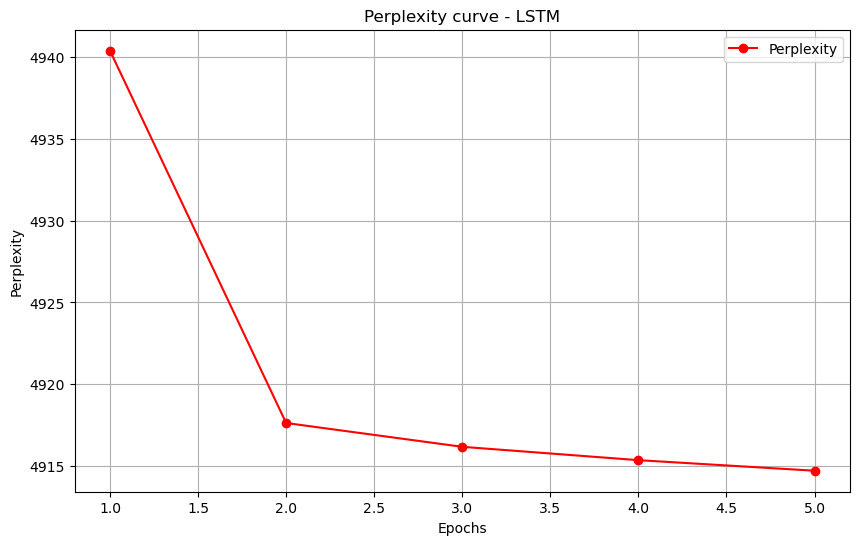

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1, N_EPOCHS + 1), list_perplexity, 'o-', color='red', label='Perplexity')
plt.title('Perplexity curve - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid()
# plt.savefig("perplexity_lstm.png")
plt.show()

In [ ]:
%store list_perplexity

Stored 'list_perplexity' (list)
